In [80]:
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from astropy.time import Time, TimeDelta
import lsst.sims.downtimeModel as down

In [111]:
tstart = Time('2023-01-01', format='isot', scale='tai')
day_offset = TimeDelta(-0.34, format='jd')

In [112]:
scheduledDowntimeData = down.ScheduledDowntimeData(tstart, start_of_night_offset=day_offset)
scheduledDowntimeData.read_data()

In [113]:
print(len(scheduledDowntimeData.downtime))
print("First downtime", "start", scheduledDowntimeData.downtime[0]['start'].isot, 
      "end", scheduledDowntimeData.downtime[0]['end'].isot)
print("Last downtime", "start", scheduledDowntimeData.downtime[-1]['start'].isot, 
      "end", scheduledDowntimeData.downtime[-1]['end'].isot)

31
First downtime start 2023-06-07T15:50:24.000 end 2023-06-14T15:50:24.000
Last downtime start 2042-10-29T15:50:24.000 end 2042-11-05T15:50:24.000


In [114]:
unscheduledDowntimeData = down.UnscheduledDowntimeData(tstart, start_of_night_offset=day_offset,
                                                    survey_length=3650*2)#, seed=3)
unscheduledDowntimeData.make_data()

In [115]:
print(len(unscheduledDowntimeData.downtime))
print("First downtime", "start", unscheduledDowntimeData.downtime[0]['start'].isot, 
      "end", unscheduledDowntimeData.downtime[0]['end'].isot)
print("Last downtime", "start", unscheduledDowntimeData.downtime[-1]['start'].isot, 
      "end", unscheduledDowntimeData.downtime[-1]['end'].isot)

155
First downtime start 2023-01-29T15:50:24.000 end 2023-01-30T15:50:24.000
Last downtime start 2042-11-18T15:50:24.000 end 2042-11-19T15:50:24.000


In [116]:
dtModel = down.DowntimeModel()

In [117]:
dtModel.config_info()

OrderedDict([('DowntimeModel_version', '0bec6a0'),
             ('DowntimeModel_sha', '0bec6a04497600aa71a01ebe8d9343335ed55342'),
             ('efd_columns', ['scheduled_downtimes', 'unscheduled_downtimes']),
             ('efd_delta_time', 0.0),
             ('target_columns', ['time'])])

In [118]:
# The EFD data for the downtime models is a little different than some of the other *Data values.
# Basically, you don't repeatedly query it (although that may make sense in production),
# and then you just pass the entire downtime arrays into the model.
sched_downtime = scheduledDowntimeData()
unsched_downtime = unscheduledDowntimeData()
efdData = {'scheduled_downtimes': sched_downtime,
           'unscheduled_downtimes': unsched_downtime}

In [119]:
# However, the target dict takes the current (or desired) time as its 'target'.
targetDict = {'time': tstart}

In [120]:
# And then the downtime model tells you:
# State of the system (True = system is down)
# End of current downtime
# Next expected (scheduled) downtime.
#  .. so the model provides some 'blindness' to the unscheduled downtime.

modelData = dtModel(efdData, targetDict)

In [121]:
modelData

{'status': False,
 'end': None,
 'next': <Time object: scale='tai' format='isot' value=2023-06-07T15:50:24.000>}

In [122]:
# Fast forward to a time that we know is in a downtime period..
targetDict = {'time': scheduledDowntimeData.downtime[0]['start']}
modelData = dtModel(efdData, targetDict)
modelData

{'status': True,
 'end': <Time object: scale='tai' format='isot' value=2023-06-14T15:50:24.000>,
 'next': <Time object: scale='tai' format='isot' value=2023-11-03T15:50:24.000>}

In [125]:
# And let's check in on the number of downtime nights and what they look like.
# Remember that defaults cover 20 years (so cut results in half)

In [126]:
unschedT = unscheduledDowntimeData.downtime
print(unschedT[0], unschedT[-1])
g = lambda x : print(x['start'].datetime.date(), x['end'].datetime.date(), (x['end'] - x['start']).jd)
for dt in unschedT:
    g(dt)

(<Time object: scale='tai' format='isot' value=2023-01-29T15:50:24.000>, <Time object: scale='tai' format='isot' value=2023-01-30T15:50:24.000>, 'minor event') (<Time object: scale='tai' format='isot' value=2042-11-18T15:50:24.000>, <Time object: scale='tai' format='isot' value=2042-11-19T15:50:24.000>, 'minor event')
2023-01-29 2023-01-30 1.0
2023-02-03 2023-02-06 3.0
2023-03-02 2023-03-09 7.0
2023-04-02 2023-04-03 1.0
2023-04-07 2023-04-08 1.0
2023-04-24 2023-04-25 1.0
2023-06-04 2023-06-05 1.0
2023-08-05 2023-08-06 1.0
2023-09-22 2023-09-29 7.0
2023-10-19 2023-10-20 1.0
2023-12-25 2023-12-28 3.0
2024-02-20 2024-02-21 1.0
2024-07-17 2024-07-18 1.0
2024-07-30 2024-07-31 1.0
2024-08-09 2024-08-10 1.0
2025-02-21 2025-02-22 1.0
2025-05-05 2025-05-08 3.0
2025-05-09 2025-05-10 1.0
2025-06-15 2025-06-16 1.0
2025-08-08 2025-08-09 1.0
2025-09-14 2025-09-15 1.0
2025-09-27 2025-09-28 1.0
2025-11-20 2025-11-23 3.0
2025-12-08 2025-12-11 3.0
2026-01-01 2026-01-02 1.0
2026-04-01 2026-04-02 1.0
2026

In [127]:
schedT = scheduledDowntimeData.downtime
print(schedT[0], schedT[-1])
g = lambda x : print(x['start'].datetime.date(), x['end'].datetime.date(), (x['end'] - x['start']).jd)
for dt in schedT:
    g(dt)

(<Time object: scale='tai' format='isot' value=2023-06-07T15:50:24.000>, <Time object: scale='tai' format='isot' value=2023-06-14T15:50:24.000>, 'general maintenance') (<Time object: scale='tai' format='isot' value=2042-10-29T15:50:24.000>, <Time object: scale='tai' format='isot' value=2042-11-05T15:50:24.000>, 'general maintenance')
2023-06-07 2023-06-14 7.0
2023-11-03 2023-11-10 7.0
2024-06-06 2024-06-13 7.0
2024-11-02 2024-11-09 7.0
2025-06-06 2025-06-20 14.0
2026-06-06 2026-06-13 7.0
2026-11-02 2026-11-09 7.0
2027-06-06 2027-06-20 14.0
2028-06-05 2028-06-12 7.0
2028-11-01 2028-11-08 7.0
2029-06-05 2029-06-19 14.0
2030-06-05 2030-06-12 7.0
2030-11-01 2030-11-08 7.0
2031-06-05 2031-06-19 14.0
2032-06-04 2032-06-11 7.0
2032-10-31 2032-11-07 7.0
2033-06-04 2033-06-18 14.0
2034-06-04 2034-06-11 7.0
2034-10-31 2034-11-07 7.0
2035-06-04 2035-06-18 14.0
2036-06-03 2036-06-10 7.0
2036-10-30 2036-11-06 7.0
2037-06-03 2037-06-17 14.0
2038-06-03 2038-06-10 7.0
2038-10-30 2038-11-06 7.0
2039-06

Text(0, 0.5, 'Number of unscheduled downtime intervals')

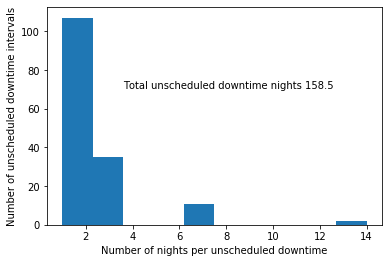

In [129]:
g = lambda x: (x['end'] - x['start']).jd
dts = []
for dt in unschedT:
    dts.append((g(dt)))

n, b, p = plt.hist(dts)
plt.figtext(.3, .6, f'Total unscheduled downtime nights {sum(dts)/2}')
plt.xlabel("Number of nights per unscheduled downtime")
plt.ylabel("Number of unscheduled downtime intervals")

Text(0, 0.5, 'Number of scheduled downtime intervals')

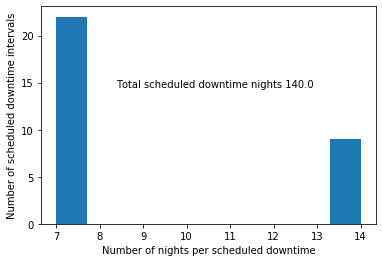

In [130]:
g = lambda x: (x['end'] - x['start']).jd
dts = []
for dt in schedT:
    dts.append((g(dt)))
n, b, p = plt.hist(dts)
plt.figtext(.3, .6, f'Total scheduled downtime nights {sum(dts)/2}')
plt.xlabel("Number of nights per scheduled downtime")
plt.ylabel("Number of scheduled downtime intervals")

(0, 7995.918000000156)

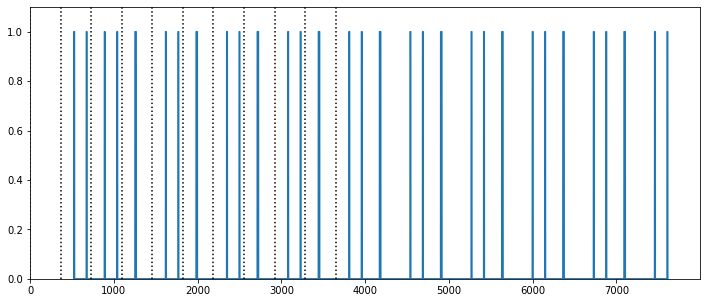

In [131]:
val = []
dts = []
for dt in schedT:
    val.append(0)
    dts.append(dt['start'].jd - 1)
    val.append(1)
    dts.append(dt['start'].jd)
    val.append(1)
    dts.append(dt['end'].jd)
    val.append(0)
    dts.append(dt['end'].jd + 1)
dts = np.array(dts)
dts = dts - 2459580
x = np.arange(0, 3652, 365)
plt.figure(figsize=(12, 5))
plt.plot(dts, val)
for yr in x:
    plt.axvline(yr, color='k', linestyle=':')
plt.ylim(0, 1.1)
plt.xlim(left=0)